# Robots Limpiadores

En un espacio representado por una cuadrícula de tamaño NxN, cada celda puede estar limpia o sucia. En este entorno, operan varias barredoras eléctricas, que son agentes autónomos responsables de limpiar la cuadrícula. Estas barredoras pueden moverse en las ocho direcciones cardinales: arriba, abajo, izquierda, derecha y las cuatro diagonales.

Cada barredora tiene las siguientes capacidades:
* **Detección:** Puede detectar si la celda donde está limpia o sucia.
* **Limpieza:** Puede limpiar la celda en la que se encuentra.
* **Movimiento:** Puede moverse a una celda adyacente si esta no está ocupada por otra barredora.
* **Posición de arranque:** Todas las celdas en posiciones al azar.

El desafío es desarrollar un sistema multiagentes que limpie la cuadrícula de la manera más eficiente posible. Definimos eficiencia como la relación entre el número de celdas limpiadas y el número de celdas recorridas por un agente.

In [17]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen de forma aleatoria.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Haremos uso de ''batch_run'' para ejecutar varias simulaciones
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [ ]:
class Stack:
    def __init__(self):
        self.__data = []
    
    def empty(self):
        return not self.__data
    
    def clear(self):
        self.__data.clear()
    
    def push(self, element):
        self.__data.append(element)
    
    def pop(self):
        if self.__data: # not empty
            self.__data.pop()
        else:
            raise Exception("No such element")
    
    def top(self):
        if self.__data: # not empty
            return self.__data[-1]
        else:
            raise Exception("No such element")
            
    def display(self):
        print(self.__data)

In [ ]:
class CleanBotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.cells_cleaned = 0
        self.cells_visited = 1
        self.previous_steps = Stack()

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, 
                                                              include_center=False)
        options = [x for x in range(len(possible_positions))]
        np.random.shuffle(options)

        hasMove = False
        for i in options:
            position = possible_positions[i]
            (x, y) = position
            if self.model.grid.is_cell_empty(position) and self.model.cells[x][y] == 1:
                self.previous_steps.push(self.pos)
                self.model.grid.move_agent(self, position)
                self.cells_visited += 1
                hasMove = True
                break

        if not hasMove:
            if self.previous_steps.empty():
                return
                
            position = self.previous_steps.top()
            if self.model.grid.is_cell_empty(position):
                self.previous_steps.pop()
                self.model.grid.move_agent(self, position)
                self.cells_visited += 1
        
    def step(self):
        if self.model.is_all_clean():
            return
            
        (x, y) = self.pos
        if self.model.cells[x][y] == 1:
            self.model.cells[x][y] = 0
            self.cells_cleaned += 1
        else:
            self.move()

In [19]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 2
    return grid

In [ ]:
class CleanBotModel(Model):
    def __init__(self, width=20, height=20, agents=5, percentage_dirty_cells=10):
        super().__init__()

        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Grid":get_grid, 
                             "Steps":lambda model : model.steps,
                             "Clean":lambda model : 1 - (model.cells.sum() / model.cells.size)},
            agent_reporters={"Efficiency":lambda agent : agent.cells_cleaned / agent.cells_visited})

        self.cells = np.zeros( (width, height) )
        count = int( (width * height * (percentage_dirty_cells / 100)) )
        while (count > 0):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 1
                count -= 1 
        
        self.steps = 0

        i = 0
        while (i < agents):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.grid.is_cell_empty( (x, y) ):
                agent = CleanBotAgent(i, self)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                i += 1

    def step(self):
        if not(self.is_all_clean()):
            self.steps += 1
        self.datacollector.collect(self)
        self.schedule.step()

    def is_all_clean(self):
        return (self.cells.sum() == 0)

In [ ]:
# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = CleanBotModel()
while not(model.is_all_clean()):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:00:00.365552


In [43]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

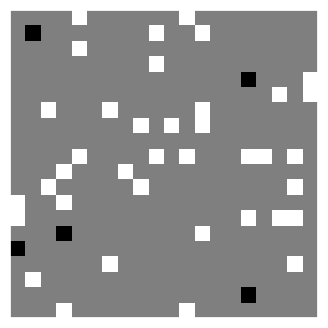

In [ ]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0, 0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i, 0])
    
anim = animation.FuncAnimation(fig, animate, frames=model.steps)

In [45]:
anim

In [ ]:
params = {"width":20, "height":20, "agents":range(5, 15, 5), "percentage_dirty_cells":10}

MAX_SIMULATIONS = 10
MAX_ITERATIONS = 2000

results = batch_run(
    CleanBotModel,
    parameters=params,
    iterations=MAX_SIMULATIONS,
    max_steps=MAX_ITERATIONS,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300150 entries, 0 to 300149
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   RunId                   300150 non-null  int64  
 1   iteration               300150 non-null  int64  
 2   Step                    300150 non-null  int64  
 3   width                   300150 non-null  int64  
 4   height                  300150 non-null  int64  
 5   agents                  300150 non-null  int64  
 6   percentage_clean_cells  300150 non-null  int64  
 7   Grid                    300150 non-null  object 
 8   Steps                   300150 non-null  int64  
 9   Clean                   300150 non-null  float64
 10  AgentID                 300150 non-null  int64  
 11  Efficiency              300150 non-null  float64
dtypes: float64(2), int64(9), object(1)
memory usage: 27.5+ MB


In [48]:
df.head()

,RunId,iteration,Step,width,height,agents,percentage_clean_cells,Grid,Steps,Clean,AgentID,Efficiency
0,0,0,0,20,20,5,10,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,0.1,0,0.0
1,0,0,0,20,20,5,10,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,0.1,1,0.0
2,0,0,0,20,20,5,10,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,0.1,2,0.0
3,0,0,0,20,20,5,10,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,0.1,3,0.0
4,0,0,0,20,20,5,10,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,0.1,4,0.0


In [49]:
new_df = df[(df.Step == MAX_ITERATIONS) & (df.AgentID == 0)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 10000 to 300147
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   RunId                   20 non-null     int64  
 1   iteration               20 non-null     int64  
 2   Step                    20 non-null     int64  
 3   width                   20 non-null     int64  
 4   height                  20 non-null     int64  
 5   agents                  20 non-null     int64  
 6   percentage_clean_cells  20 non-null     int64  
 7   Grid                    20 non-null     object 
 8   Steps                   20 non-null     int64  
 9   Clean                   20 non-null     float64
 10  AgentID                 20 non-null     int64  
 11  Efficiency              20 non-null     float64
dtypes: float64(2), int64(9), object(1)
memory usage: 2.0+ KB


In [50]:
print('Average percentage of clean cells: ', new_df['Clean'].mean())

Average percentage of clean cells:  0.99925


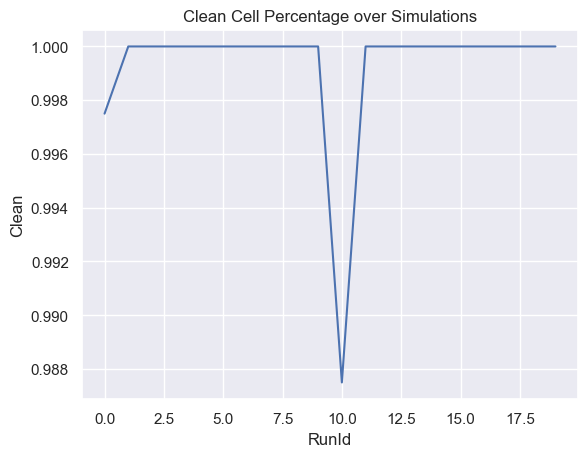

In [51]:
g = sns.lineplot(data=new_df, x="RunId", y="Clean")
g.set(title="Clean Cell Percentage over Simulations");

In [52]:
print('Average steps taken: ', new_df['Steps'].mean())

Average steps taken:  1133.7


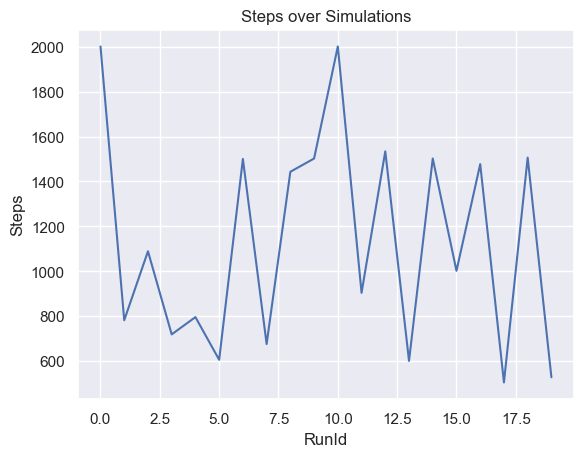

In [53]:
g = sns.lineplot(data=new_df, x="RunId", y="Steps")
g.set(title="Steps over Simulations");

In [54]:
new_df = df[(df.Step == MAX_ITERATIONS) & (df.AgentID == 0)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 10000 to 300147
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   RunId                   20 non-null     int64  
 1   iteration               20 non-null     int64  
 2   Step                    20 non-null     int64  
 3   width                   20 non-null     int64  
 4   height                  20 non-null     int64  
 5   agents                  20 non-null     int64  
 6   percentage_clean_cells  20 non-null     int64  
 7   Grid                    20 non-null     object 
 8   Steps                   20 non-null     int64  
 9   Clean                   20 non-null     float64
 10  AgentID                 20 non-null     int64  
 11  Efficiency              20 non-null     float64
dtypes: float64(2), int64(9), object(1)
memory usage: 2.0+ KB


In [55]:
print('Average efficiency of Robot 0: ', new_df['Efficiency'].mean())

Average efficiency of Robot 0:  0.029131583371863674


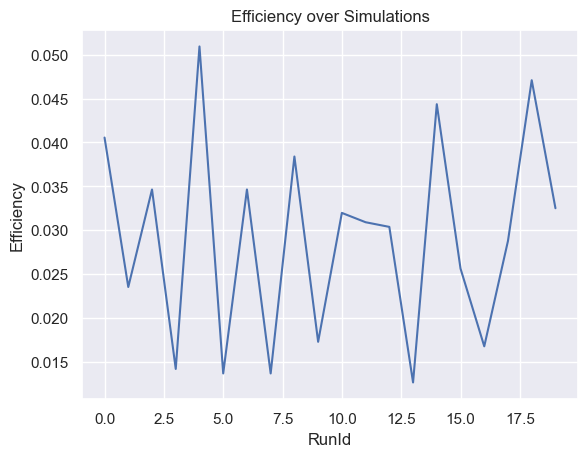

In [56]:
g = sns.lineplot(data=new_df, x="RunId", y="Efficiency")
g.set(title="Efficiency over Simulations");